In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import path
from keras import layers
from keras import models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from os import listdir, makedirs
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, InceptionV3, MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, Activation, MaxPooling2D, BatchNormalization
from keras import optimizers, regularizers
from tensorflow.keras.optimizers import SGD
from glob import glob
import cv2
from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
import h5py
from PIL import Image
from sklearn.model_selection import train_test_split

print(os.listdir("../"))
data_dir = '../'


['.ipynb_checkpoints', 'driver-dataset', 'InceptionNet-mode.ipynb', 'vgg']


In [2]:

RESOLUTION = 150
BATCH_SIZE=64

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
        "../driver-dataset/imgs/train/",
        target_size=(160, 120),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training", color_mode='grayscale')

val_generator = val_datagen.flow_from_directory(
        "../driver-dataset/imgs/train/",
        target_size=(160, 120),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation",  color_mode='grayscale')

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.


In [3]:
def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

col = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5':'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

				# c0 : safe driving


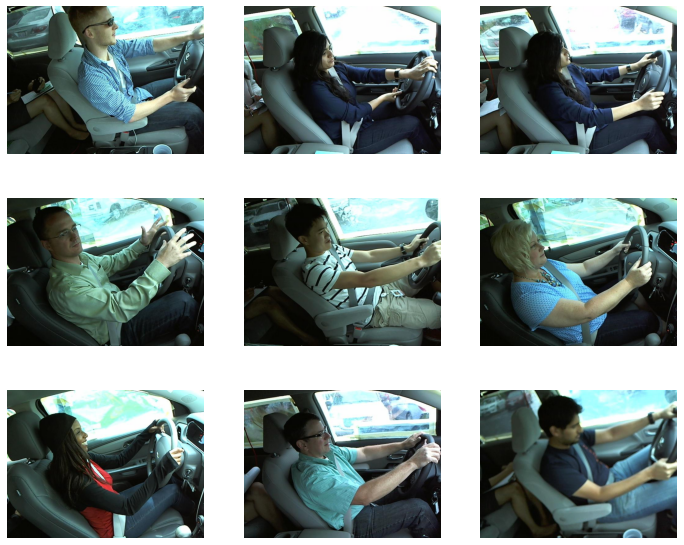

				# c1 : texting - right


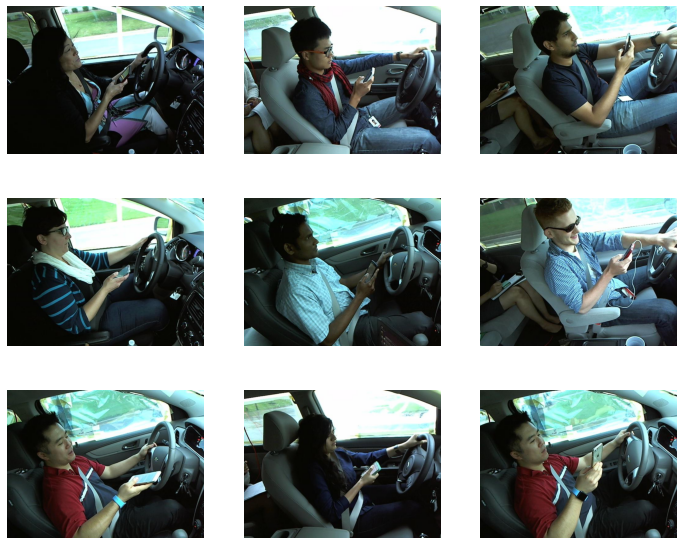

				# c2 : talking on the phone - right


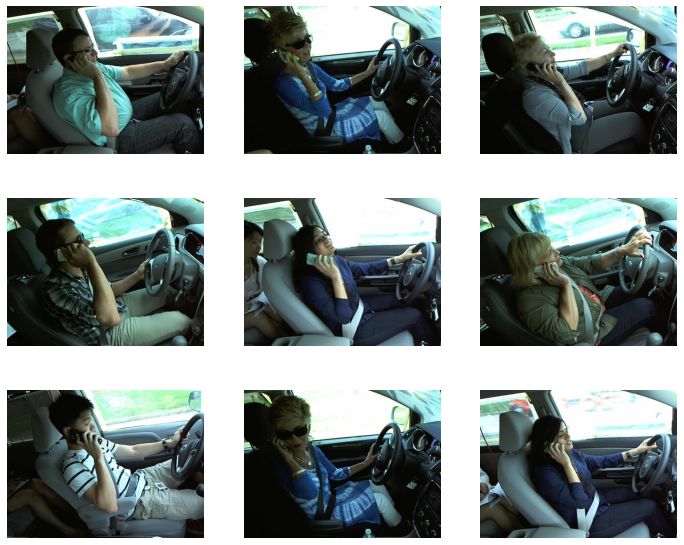

				# c3 : texting - left


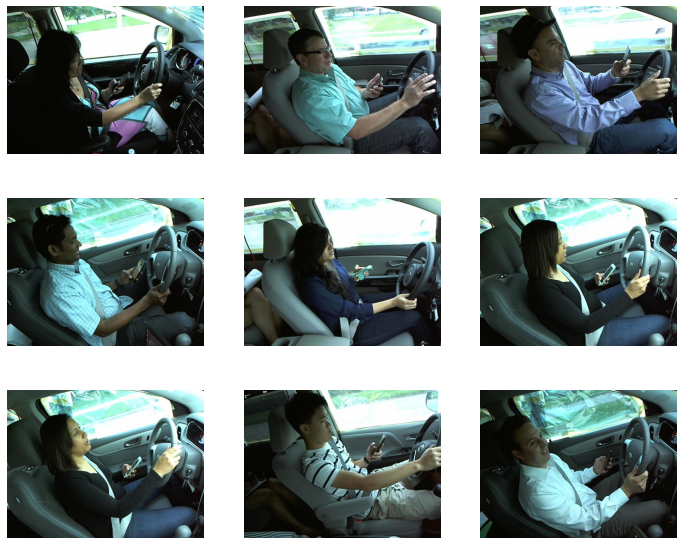

				# c4 : talking on the phone - left


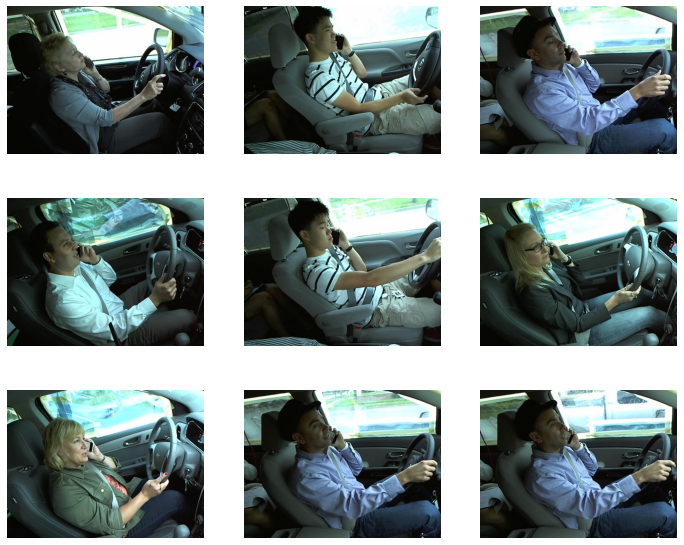

				# c5 : operating the radio


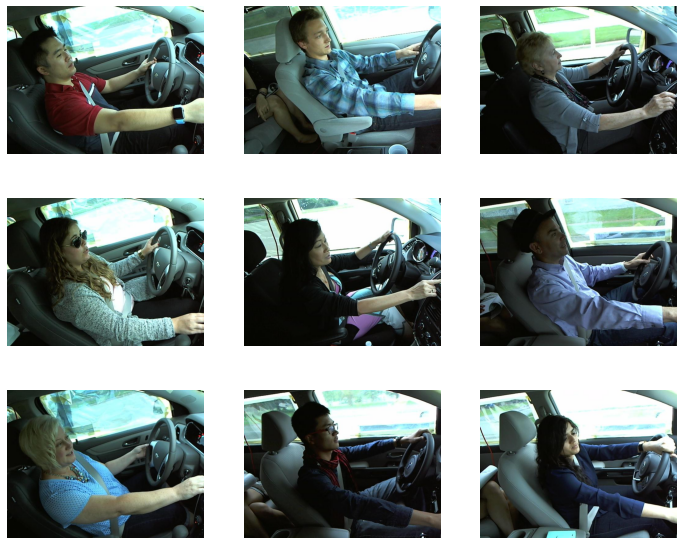

				# c6 : drinking


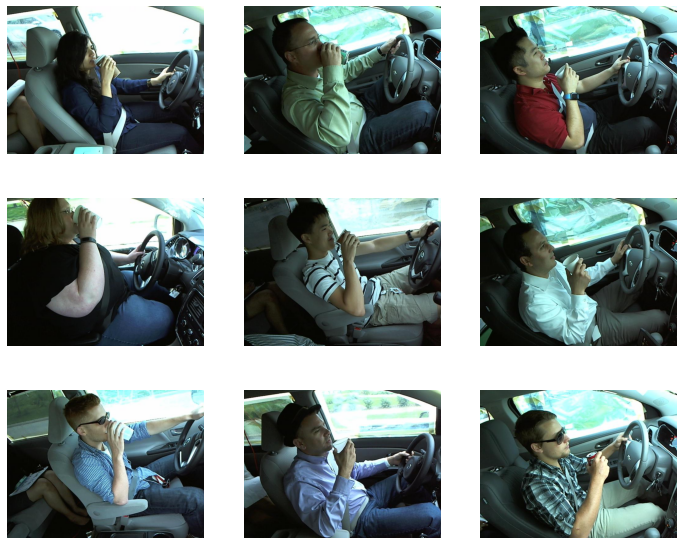

				# c7 : reaching behind


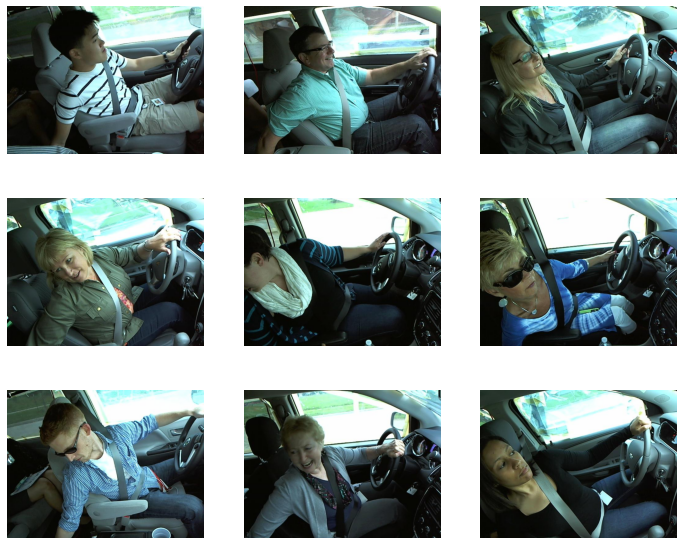

				# c8 : hair and makeup


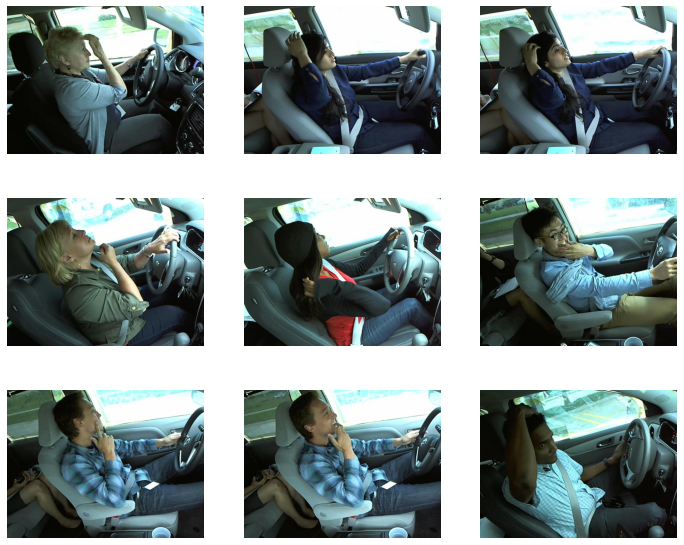

				# c9 : talking to passenger


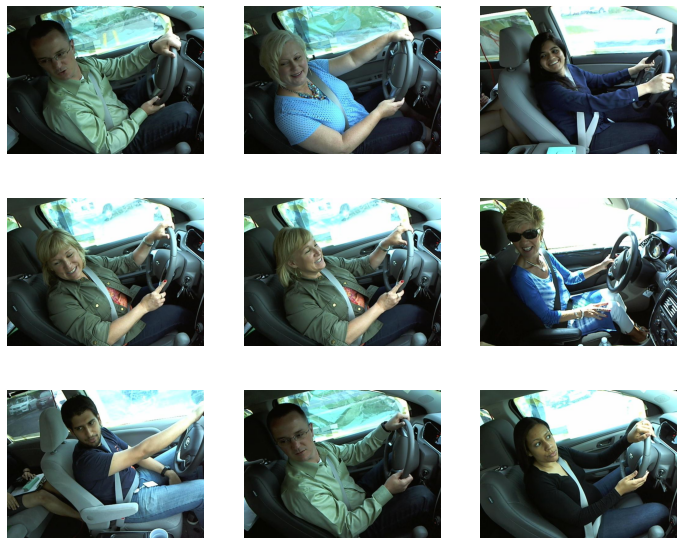

In [4]:
for label in labels:
    f, ax = plt.subplots(figsize=(12, 10))
    files = glob('{}/train/{}/*.jpg'.format(os.path.join(data_dir, 'driver-dataset/imgs'), label))
    
    print('\t\t\t\t# {} : {}'.format(label, col[label]))
    for x in range(9):
        plt.subplot(3, 3, x+1)
        image = read_image(files[x])
        plt.imshow(image)
        plt.axis('off')
    plt.show()
    

#  Model


In [7]:

def create_model():
    model = Sequential()
    # Use Batch Normalization for every conv and dense layers
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (160, 120, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.33))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation = 'softmax')) 
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

In [8]:
model = create_model()

In [17]:
history={}
def train(model, filepath):
    global history
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    n_train = 15702
    batch_size = 300
    n_valid = 6722
    history = model.fit_generator(
           train_generator,
           steps_per_epoch=n_train//batch_size,
           epochs=3,
           validation_data=val_generator,
           validation_steps=n_valid//batch_size,  callbacks=callbacks_list)
    
    
    # Plot
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    return model

Epoch 1/3
52/52 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9748
Epoch 00001: val_accuracy improved from -inf to 0.10653, saving model to weights_best.h5
52/52 [==============================] - 514s 10s/step - loss: 0.1554 - accuracy: 0.9748 - val_loss: 9.8447 - val_accuracy: 0.1065
Epoch 2/3
52/52 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9829
Epoch 00002: val_accuracy improved from 0.10653 to 0.12003, saving model to weights_best.h5
52/52 [==============================] - 533s 10s/step - loss: 0.1130 - accuracy: 0.9829 - val_loss: 9.2233 - val_accuracy: 0.1200
Epoch 3/3
52/52 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9856
Epoch 00003: val_accuracy improved from 0.12003 to 0.14773, saving model to weights_best.h5
52/52 [==============================] - 543s 10s/step - loss: 0.0882 - accuracy: 0.9856 - val_loss: 5.4030 - val_accuracy: 0.1477


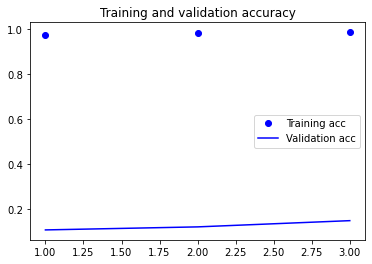

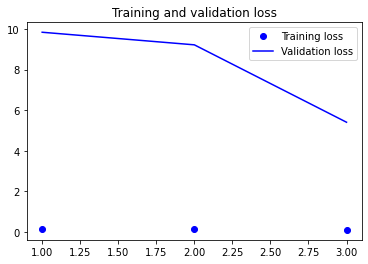

In [18]:
model = train(model, "weights_best.h5")

## Plot model loss and model accuracy

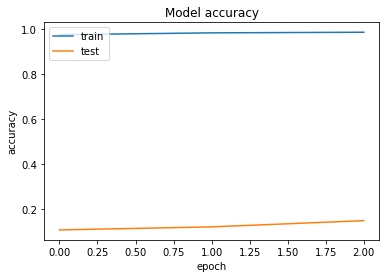

In [28]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 


In [30]:
history.history['accuracy']

[0.9747596383094788, 0.9828726053237915, 0.9855769276618958]

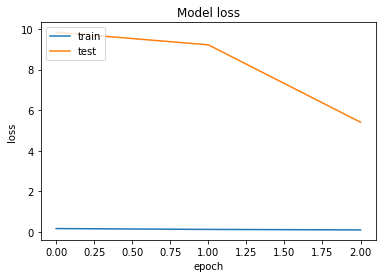

In [23]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()